# Compiler

## Network container class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class Program:
    # this class contains in a structured manner matrices and biases
    # which encode the semantics of the program network, in the same fashion
    # of the source code of a program
    def __init__(self, topology , activation_functions_list):
        self.topology = topology
        self.activation_functions_list = activation_functions_list
        self.W = [ 0 for t in topology[:-1]]
        self.b = [ 0 for t in topology[:-1]]
    def random_init_weights(self):
        for layer in range(len(self.topology[:-1])):
            self.W[layer] = np.random.normal( size = (self.topology[layer + 1] , self.topology[layer] ) )**2
            size = self.W[layer].shape[0] * self.W[layer].shape[1] 
            for i in range(size - int(np.sqrt(size))):
                r = np.random.choice(len(self.W[layer]))
                c = np.random.choice(len(self.W[layer].T))
                self.W[layer][r,c] = 0.   # adding some sparsity
                
            self.b[layer] = np.random.normal( size = self.topology[layer + 1] )
    def print(self):
        for i,layer in enumerate(self.topology[:-1]):
            print("layer %d->%d "%(i,i+1))
            print("W.shape = %s \t b.shape = %s" % (str(self.W[i].shape),str(self.b[i].shape)))
    def visualize_weights(self):
        for w in self.W:
            print(w.shape)
            plt.figure(figsize=(10,10))
            plt.imshow(w > 0.)        

## Sparsification algorithm

## IR production

### Lightweight trees representation

In [2]:
class c:
    # every element is a node in the tree.
    # the first argument denotes the name of the node ; the possible next arguments are a list of the sons.
    # Note that nodes without sons are simply leaf (eg. ADD, MUL,...)
    def __init__(self, ID, *args):
        self.id   = ID
        self.sons = list()
        for arg in args:
            self.sons.append(arg)
    def print(self,level = 0):
        print( ("\t" * level) + str(self.id) )
        for s in self.sons:
            s.print(level + 1)
    def __str__(self):
        ret = str(self.id)
        if len(self.sons) > 0:
            ret += "("
            for s in self.sons:
                ret += str(s)
                if s != self.sons[-1]:
                    ret += ','
            ret += ")"
        return ret
    def flatten(self):
        ret = []
        ret += [self.id]
        for s in self.sons:
            ret += s.flatten()
        return ret

### IR production function

In [185]:
def IR(program, compile_time_data = True):
    # for every layer
    ### print("y = input")
    ret = list()
    
    for layer,t in enumerate(program.topology[1:]):
        IR_instruction = c("COMMENT", c("START"))
        ### print(IR_instruction)
        ret.append(IR_instruction)
        
        f = program.activation_functions_list[layer]
        R_offset = program.topology[layer]
        for i in range(len(program.b[layer])): # for every row
            #print("R[%d] = 0" % (i))
            #print("MOVE( TEMP(%d) , CONST(0) )" % (i + R_offset))
            IR_instruction = c(
                    "MOVE",
                     c("TEMP" , c(i + R_offset) ),
                     c("CONST", c(0))
            )
            ### print(str(IR_instruction))
            ret.append(IR_instruction)
            
            
        for i in range(len(program.W[layer])): # for every row
            for j in range(len(program.W[layer].T)): # for every column
                if( program.W[layer][i,j] != 0):
                    # if there is zero is useless to compute the contribution
                    #print("->MOVE(TEMP(%d),BINOP(ADD,TEMP(%d),BINOP(MUL,CONST(%f),TEMP(%d)))) " % (i + R_offset,i + R_offset, program.W[layer][i,j],i )) # COMPILE DATA HYPOTHESIS
                    IR_instruction = c(
                        "MOVE",
                        c("TEMP",
                            c(i + R_offset)
                        ),
                        c("BINOP",
                            c("ADD"),
                            c("TEMP",
                                c(i + R_offset)
                            ),
                            c("BINOP",
                                c("MUL"),
                                c("CONST",
                                     c(program.W[layer][i,j])
                                 ),
                                c("TEMP",
                                 c(j)
                                 )
                            )
                        )
                    )
                    #print(IR_instruction)
                    ret.append(IR_instruction)
                else:
                    0
                    ### print("# here there was a 0 so we exploit sparsity ")
                    
        for i in range(len(program.b[layer])): # for every row
            # a priori in compile time since the amount of "repetitions" doens't scale quadratically , in opposite to weights
            #print("->MOVE(TEMP(%d),BINOP(ADD,TEMP(%d),CONST(%f)))" % (i, i + R_offset , program.b[layer][i]) )
            IR_instruction = c("MOVE",
                                c("TEMP",
                                 c(i + R_offset)
                                 ),
                                c("BINOP",
                                 c("ADD"),
                                 c("TEMP",
                                   c(i + R_offset)
                                  ),
                                 c("CONST",
                                  c(program.b[layer][i])
                                  )
                                 )
                                )
            ### print((IR_instruction))
            ret.append(IR_instruction)
        for i in range(len(program.b[layer])): # for every row
            #print("y[%d] = f(y[%d])" % (i,i))
            #print("MOVE( TEMP(%d) , CALL( %s, TEMP(%d) ) )" % (i,f,i) )
            IR_instruction = c("MOVE",
                c("TEMP",
                     c(i + R_offset)
                 ),
                c("CALL",
                     c(f),
                     c("TEMP",
                          c(i + R_offset)
                      )
                 )
            )
            ### print(IR_instruction)
            ret.append(IR_instruction)
        IR_instruction = c("COMMENT", c("END"))
        ### print(IR_instruction)
        ret.append(IR_instruction)
    return ret

## Register and memory allocation

### Temporary variables statistics class

In [186]:
class TemporaryVariablesStatistics:
    def __init__(self):
        self.temp_usage_map = {}
    def increment(self,temp_variable):
        old_value = self.temp_usage_map.get(temp_variable)
        if old_value == None:
            old_value = 0
        self.temp_usage_map[temp_variable] = old_value + 1
    def get_data(self):
        return self.temp_usage_map
    def vectorize(self):
        arr = []
        for s in self.get_data():
            arr.append( [ s, self.get_data()[s]] )
        arr = np.array(arr)                                                              # builds a tempstable [ temp | usage ]
        arr = arr[ arr[:,1].argsort()[-1::-1] ]                                          # sort the tempstable by usage  (decreasing)
        return arr
    
    def print(self):
        for t in self.temp_usage_map:
            print("%d --> %d" % (t , self.temp_usage_map[t]) )

### Register allocation data class

In [187]:
"sx".startswith("x")

False

In [188]:
class RegisterAllocationData:
    def __init__(self):
        self.temp_reg_map = {}
    
    def get(self,temp_variable):
        return self.temp_reg_map[temp_variable]
    
    def insert(self,temp_variable, register):
        self.temp_reg_map[temp_variable] = register
    def get_data(self):
        return self.temp_reg_map
    
    def rename(self,old_reg_name, new_reg_name):
        for t in self.temp_reg_map:
            if self.temp_reg_map[t] == old_reg_name:
                self.temp_reg_map[t] = new_reg_name
    
    def get_unitialized_temps(self):
        # returns the list of temps that have a register starting with "register_"
        ret = list()
        for s in self.temp_reg_map:
            if self.temp_reg_map[s].startswith("register_"):
                ret.append(s)
        return ret
    
    def get_initialized_registers(self):
        # returns a list of the register ACTUALLY used (no place holder)
        ret = list()
        for s in self.temp_reg_map:
            if not self.temp_reg_map[s].startswith("register_"):
                ret.append(self.temp_reg_map[s])
        return ret
    
    def get_variables_list(self):
        ret = list()
        for s in self.temp_reg_map:
            ret.append(s)
        return ret
    
    def get_input_temps(self, prev_layer_size):
        all_vars = np.array(self.get_variables_list())
        ret      = list()
        for var in all_vars:
            if var < prev_layer_size:
                ret.append([var, self.temp_reg_map[var]])
        return np.array(ret)
    
    def get_output_temps(self, prev_layer_size):
        all_vars = np.array(self.get_variables_list())
        ret      = list()
        for var in all_vars:
            if var >= prev_layer_size:
                ret.append([var, self.temp_reg_map[var]])
        return np.array(ret)
    
    def print(self):
        for t in self.temp_reg_map:
            print(t , "\t", self.temp_reg_map[t] )
    def contains(self,tmp_name):
        return tmp_name in self.temp_reg_map

### Memory allocation data class

In [189]:
class MemoryAllocationData:
    def __init__(self):
        self.temp_mem_map = {}
        
    def insert(self,temp_variable, address):
        self.temp_mem_map[temp_variable] = address
        
        
    def batch_set(self, list_of_temps, list_of_addresses):
        for tmp_id, mem_addr in zip(list_of_temps,list_of_addresses):
            self.temp_mem_map[tmp_id] = mem_addr
        
    def get_data(self):
        return self.temp_mem_map
    
    def get(self,x):
        return self.temp_mem_map[x]
    
    def get_variables_list(self):
        ret = list()
        for s in self.temp_mem_map:
            ret.append(s)
        return ret
    
    def get_input_temps(self, prev_layer_size):
        all_vars = np.array(self.get_variables_list())
        return all_vars[all_vars < prev_layer_size]
    
    def get_output_temps(self,prev_layer_size):
        all_vars = np.array(self.get_variables_list())
        return all_vars[all_vars >= prev_layer_size]
    
    def print(self):
        for t in self.temp_mem_map:
            print(t , "\t", self.temp_mem_map[t] )

### Block Signals

In [190]:
class BlockSignals:
    def __init__(self, memory_allocation_object):
        # initialize an empty dictionary starting from the variables name
        self.memory_allocation_object = memory_allocation_object
        self.temp_signals_map = {}
        for t in memory_allocation_object.get_data():
            self.temp_signals_map[t] = []
        
    def add_tick(self, temp_variables):
        temp_variables          = np.intersect1d(temp_variables, self.memory_allocation_object.get_variables_list())
        all_temporary_variables = self.memory_allocation_object.get_variables_list()
        # push 0 in the lists of unused temps and 1 in the list of the used temp
        for t in all_temporary_variables:
            self.temp_signals_map[t].append(0)
        for t in temp_variables:
            self.temp_signals_map[t][-1] = 1.
            
    def get_data(self):
        return self.temp_signals_map

### Interface Communication between blocks

In [284]:
class MemoryToRegisterFlow:
    # contains the information about the movement of information from a memory
    # cell to a register from a matrix mult to the next one
    def __init__(self, mem_address, register):
        self.mem_address = mem_address
        self.register    = register
    def print(self):
        print("M2R flow\t%s\t->\t%s" % (self.mem_address,self.register))
class RegisterToMemoryFlow:
    # contains the information about the movement of information from a register 
    # to a memory cell from a matrix mult to the next one
    def __init__(self, register, mem_address):
        self.mem_address = mem_address
        self.register    = register
    def print(self):
        print("R2M flow\t%s\t->\t%s" % (self.register,self.mem_address))

class RegisterRenameFlow:
    # contains the information about the movement of information from a register 
    # to a memory cell from a matrix mult to the next one
    def __init__(self, register_placeholder, register_name):
        self.register_placeholder = register_placeholder
        self.register_name        = register_name
    def print(self):
        print("R2R flow\t%s\t->\t%s" % (self.register_placeholder,self.register_name))

        
class InterfaceCommunication:
    # contains the list of movements "flows" between two matrix mult blocks
    def __init__(self):
        self.reg2memFlows = list()
        self.mem2regFlows = list()
        self.reg2regFlows = list()
    def insert(self,flow):
        if type(flow).__name__ == "RegisterToMemoryFlow":
            self.reg2memFlows.append(flow)
        else:
            if type(flow).__name__ == "MemoryToRegisterFlow":
                self.mem2regFlows.append(flow)
            else:
                if type(flow).__name__ == "RegisterRenameFlow":
                    self.reg2regFlows.append(flow)
                    
    def getReg2MemFlows(self):
        return self.reg2memFlows
    def getMem2RegFlows(self):
        return self.mem2regFlows
    def getReg2RegFlows(self):
        return self.reg2regFlows
    
    def print(self):
        reg2mem = self.getMem2RegFlows()
        mem2reg = self.getReg2MemFlows()
        reg2reg = self.getReg2RegFlows()
        for rm in reg2mem:
            rm.print()
        for mr in mem2reg:
            mr.print()
        for rr in reg2reg:
            rr.print()
        
# interface[layer_1,layer_2] = InterfaceCommunication()
# interface[layer_1,layer_2].insert( RegisterToInputFlow('AX', 0x1234))
# interface[layer_1,layer_2].insert( RegisterToInputFlow('BX', 0x1235))
# interface[layer_1,layer_2].insert( RegisterToInputFlow(0x1236, 'AX'))

A = InterfaceCommunication()
A.insert( RegisterToMemoryFlow("AX",0) )
A.insert( RegisterToMemoryFlow("BX",1) )
A.insert( MemoryToRegisterFlow(2, "AX") )
A.insert( RegisterRenameFlow("register_0", "AX") )
A.print()

M2R flow	2	->	AX
R2M flow	AX	->	0
R2M flow	BX	->	1
R2R flow	register_0	->	AX


### Theoretical argument : memory allocation

Suppose that we have some kind of distance between temporary variables in a <b>matrixmult</b>. <br>
Therefore we have a collection of distance matrices $\{D_{1,2},D_{2,3},...,D_{N-1,N}\}$ <br>
We can formulate the following optimization problem <br><br>
$
    \text{Find $\{P_{1,2},P_{2,3},...,P_{N-1,N}\}$ permutations of 
    $\{ [1,n_{1,2}], [1,n_{2,3}],... ,[1,n_{N-1,N}] \}$ }
$ <br>
$
\text{such that
    $D(P_{i,i+1}) \sim D_{i,i+1} \ \ \ \forall i$
}
$ <br>
$
\text{Subject to
    $ (P_{i,i+1})_{\text{output (only memory)}} = (P_{i+1,i+2})_{\text{input (only memory)}}  \ \ \forall i$
}
$

### Proposed algorithm

$
\text{$P_0 \leftarrow$ Permutation$(Temp_{\mathcal l,\mathcal l + 1})$ optimal}\\
\text{${\bf for } \ \ \ i,(layer,layer+1) \in temps $ : } \\
\hspace{2em} \text{$ P_i \leftarrow $ Permutation$(Temp_{\mathcal l_i,\mathcal l_{i+1}})$ optimal subject to $P_i^{input} = P_{i-1}^{output}$ }
$

### Constrained Permutation Class

In [285]:
class constrainedPermutation:
    def __init__(self, constraint, trivial_init = True, init_vector = None):
        # constraint = vector of -1, with the exception of the "fixed points" of the permutations
        #              e.g.   -1 -1 4 3 -1
        #              reads as "all the permutations of 01234" such that the third element is 4 and the fourth is 3
        self.constraint = constraint
        if trivial_init == True:
            self.value      = np.arange(len(constraint))
            for i in np.arange(len(constraint))[constraint != -1]:
                # find the value at the position i
                to_swap_A = i                                      # position 1
                to_swap_B = np.argmax(self.value == constraint[i]) # position 2
                tmp       = self.value[to_swap_A]
                self.value[to_swap_A] = self.value[to_swap_B]
                self.value[to_swap_B] = tmp
        else:
            self.value = init_vector.copy()
    
    def get_neighbor(self):
        feasible = np.arange(len(self.constraint))[self.constraint == -1]
        old = self.value[feasible]
        a        = np.random.choice(len(feasible))
        b        = np.random.choice(len(feasible))
        temp     = feasible[a]
        feasible[a] = feasible[b]
        feasible[b] = temp
        ret = self.value.copy()
        ret[feasible] = old
        return constrainedPermutation(self.constraint,False,ret)
    
    def get_indexes(self):
        return self.value
    
    def distance_matrix(self):
        return np.array([
            [
                    np.linalg.norm(a - b)
                for b in self.value
            ]
            for a in self.value
        ])
    
    def print(self):
        print(self.value)
ret = list()
for i in range(10000):
    ret.append( constrainedPermutation(np.array([-1.,-1.,2,3,4,-1,-1,-1])).get_neighbor().value )
ret = np.array(ret)
ret.mean(axis = 0)

array([1.5511, 2.0949, 2.    , 3.    , 4.    , 4.5228, 5.1306, 5.7006])

In [286]:
def affinity(permutation, distance_matrix):
    # compute the permutation distance matrix
    d_hat = permutation.distance_matrix()
    return np.linalg.norm( d_hat - distance_matrix.argsort(axis = 1) )

### Allocator class

In [287]:
def compute_temporary_mapping_table_and_table_inv(temps_input, temps_input_name_at_previous_block):
    temporary_mapping_table =  {}
    temporary_mapping_table_inv = {}
    for a,b in zip(temps_input,temps_input_name_at_previous_block):
        temporary_mapping_table[b] = a
        temporary_mapping_table_inv[a] = b   
    return temporary_mapping_table,temporary_mapping_table_inv

In [288]:
def compute_output_prev_block_register_mapping(temps_in_reg_output, regs_output):
    print("OUTPUT TEMPORARIES IN PREVIOUS LAYER IN REGISTERS")
    output_prev_block_register_mapping = {}
    print("output_{i-1}\tREG")
    for tro in np.c_[temps_in_reg_output, regs_output]:
        print("%s\t\t%s" % (tro[0],tro[1]))
        output_prev_block_register_mapping[int(tro[0])] = tro[1]
    return output_prev_block_register_mapping

In [289]:
def print_table(temps_in_mem_input, 
                mems_input,
                temps_in_mem_output,
                mems_output,
                temps_in_reg_input,
                regs_input,
                temps_in_reg_output,
                regs_output,
                i
               ):
                print("### [%d] INPUT TEMPS MEMORY TABLE ###" % 0)
                for r in np.c_[temps_in_mem_input, mems_input]:
                    print("%d\t%d" % (r[0],r[1]))
                print("### [%d] OUTPUT TEMPS MEMORY TABLE ###" % 0)
                for r in np.c_[temps_in_mem_output, mems_output]:
                    print("%d\t%d" % (r[0],r[1]))
                print("### [%d] INPUT TEMPS REGISTER TABLE ###" % 0)
                for r in np.c_[temps_in_reg_input, regs_input]:
                    print("%s\t%s" % (r[0],r[1]))
                print("### [%d] OUTPUT TEMPS REGISTER TABLE ###" % 0)
                for r in np.c_[temps_in_reg_output, regs_output]:
                    print("%s\t%s" % (r[0],r[1]))
            

+---------+
0 	 c
20 	 d
2 	 e
3 	 f
+---------+
22 	 register_0
26 	 register_1
24 	 register_2
25 	 register_3
+---------+
10 	 register_0
7 	 register_1
6 	 register_2
4 	 register_3
MEMORY =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

MEM ALLOC DATA [len DS = 3]

{4: 0, 6: 1, 1: 2, 15: 3, 16: 4, 17: 5, 18: 6, 14: 7, 13: 8, 12: 9, 10: 10, 9: 11, 8: 12, 7: 13, 5: 14, 19: 15, 11: 16}
{'f', 'e', 'd', 'c'}
>>> 24
>>> 25
>>> 26
>>> 22
|unconstrained| = 9
constrained addresses =  [14, 13, 4, 15, 5, 0, 2, 1, 8, 7, 6, 11, 3, 12, 9, 10, 16]
MEMORY MASK = [17 18 19 20 21 22 23 24 25]
1
{29: 0, 21: 1, 27: 2, 20: 3, 28: 4, 23: 5, 15: 6, 4: 7, 7: 8, 1: 9, 8: 10, 2: 11, 17: 12, 11: 13, 18: 14, 14: 15, 13: 16, 16: 17, 10: 18, 5: 19, 3: 20, 0: 21, 12: 22, 6: 23, 9: 24, 19: 25}
$$$ REG 1
----
0 	 c
20 	 d
2 	 e
3 	 f
-----
----
22 	 c
26 	 d
24 	 f
25 	 e
-----
----
10 	 register_0
7 	 register_1
6 	 register_2
4 	 register_3
-----
$$$ MEM 1
----
4 	 13
6 	 15


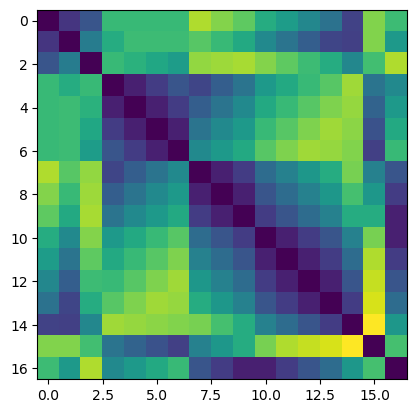

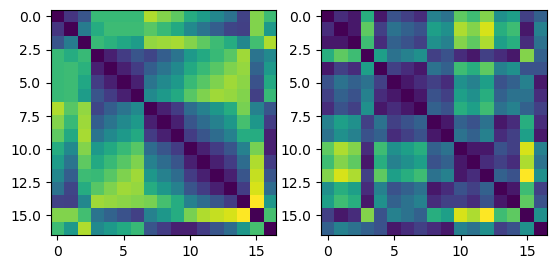

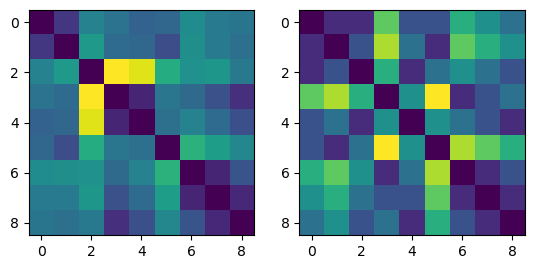

In [314]:
from sklearn.manifold import MDS
class Allocator:
    def __init__(self, ir, program, register_names):
        self.register_allocation_data = []  # register allocations for every matrix multiplication operation
        self.memory_allocation_data   = []  # memory allocations for every matrix multiplication operation
        self.interfaces               = {}
        self.register_names           = register_names
        self.program                  = program
        # ------------------------------
        # Register allocation subroutine
        
        # compute the usage of each temp
        temp_statistics = self.most_used_temps(ir)   # produces a list of register statistics objects
        
        # 
        self.register_allocation_and_memory_alloc_init(temp_statistics, register_names)
        self.memory_allocation(
                self.compute_signals_distance_matrix(
                    self.compute_signals(ir)
                )
        )
    ########################################################################################
    # Register allocation
    ########################################################################################
    
    def most_used_temps(self, ir):
        # IN   : takes as input an intermediate representation
        # OUT  : produces a list of TemporaryVariableStatistics objects, one for each matrix mult
        statistics_per_block = list()
        
        for ir_instruction in ir:                                                            # iterate over the IR statements
            if(ir_instruction.id == "COMMENT"):                                              # 
                if(ir_instruction.sons[0].id == "START"):
                    statistics_per_block.append(TemporaryVariablesStatistics())              # i create a temporaryvariablestatistcs
            else:
                unrolled_ir = ir_instruction.flatten()                                       # unroll the statemenet
                temps_in_statement   = list()                                                # container for temps variables in the current statement
                for u,val in zip(unrolled_ir[:-1],unrolled_ir[1:]):  
                    if u == "TEMP": 
                        temps_in_statement.append(val)                                       
                                                                                             # now "temps_in_statement" contains only the values of the temporary variables
                for t in temps_in_statement:                                                 # count the usage of each temporal 
                    statistics_per_block[-1].increment(t)                                       # the current temporary variable statistics is updated 
        return statistics_per_block
    
    def register_allocation_and_memory_alloc_init(self, statistics_list , register_names):
        # IN  : a statistics list obtained from  most_used_temps , register names
        # OUT : a registerAllocation object
        
        # convert the dictionary to an array
        temp_stats_per_block = list()
        first_block = True
        for stat in statistics_list:
            # I transform the dictitonary in a sorted-by-usage vector
            arr = stat.vectorize()
            #print(arr)
            
            # I initialize a Registerallocation  object
            reg_data = RegisterAllocationData()   
            
            # for every register i take an element, starting from the beginning, of the array
            temp_var_count = 0
            for r_id,r in enumerate(register_names):
                if temp_var_count >= len(arr):
                    break
                if first_block:     # registers are decided a priori only in the first block
                    reg_data.insert(arr[temp_var_count,0],r)                                  # i add as a used register the temporary variables with more usage
                else:
                    reg_data.insert(arr[temp_var_count,0],"register_%d" % r_id)
                temp_var_count += 1
            self.register_allocation_data.append(reg_data)                                    # i append the register allocation data obtained to the list of RAD
            
            # I also initialize the "slots" for the memory allocation data
            mem_data = MemoryAllocationData()                                                 
            for t in range(temp_var_count, len(arr)):
                mem_data.insert(arr[t,0], -1)                                                 # initializa with -1
            self.memory_allocation_data.append(mem_data)                                      # i add them to the list
            first_block = False
        
        for r in self.register_allocation_data:
            print("+---------+")
            r.print()
        
        return 0
    
    ########################################################################################
    # Memory allocation
    ########################################################################################

    def compute_signals(self, ir):
        # takes as input an intermediate repr and a register allocation output
        signals_per_block = list()
 
        curr_alloc_block = 0
    
        for ir_instruction in ir:
            if(ir_instruction.id == "COMMENT"):
                if(ir_instruction.sons[0].id == "START"):
                    curr_memory_alloc_block = self.memory_allocation_data[curr_alloc_block]
                    signals_per_block.append(BlockSignals(curr_memory_alloc_block))                       
                    curr_alloc_block += 1

            unrolled_ir = ir_instruction.flatten()
            temps_in_statement   = list()
            for u,val in zip(unrolled_ir[:-1],unrolled_ir[1:]):
                if u == "TEMP":
                    temps_in_statement.append(val)      
                    
            signals_per_block[-1].add_tick(temps_in_statement)
        return signals_per_block
    
    def compute_signals_distance_matrix(self, signals):
        # IN   : takes as input a collection of TempVarSignals
        # OUT  : produces a 
        inverse_mappings = list()
        mappings = list()          # mapping between the rows of the matrix and the temp_var
        Ds = list()                # list of matrices
        
        for signals_block in signals:
            D = np.zeros((len(signals_block.get_data()),len(signals_block.get_data())))
            mapping = {}
            inverse_mapping = {}
            for i,a in enumerate(signals_block.get_data()):
                mapping[i] = a
                inverse_mapping[a] = i
                for j,b in enumerate(signals_block.get_data()):  
                    v_a = np.arange(len(signals_block.get_data()[a]))[np.array(signals_block.get_data()[a]) == 1.]
                    v_b = np.arange(len(signals_block.get_data()[b]))[np.array(signals_block.get_data()[b]) == 1.]
                    distanza = 0.5 * (np.mean([ np.min(np.abs(s_1 - v_b)) for s_1 in v_a]) + np.mean([ np.min(np.abs(s_2 - v_a)) for s_2 in v_b]))
                    D[i,j] = distanza
            Ds.append(D)
            mappings.append(mapping)
            inverse_mappings.append(inverse_mapping)
        return Ds, mappings, inverse_mappings
    
    def anneal(self,
               unconstrainedTemps,     # temporary unconstrained
               addresses,              # list of available memory addresses
               Ds,                     # distance matrix
               inverse_mapping):       # mapping between rows of the distance matrix and temps
        print(inverse_mapping)
        # initialize a random association
        
        association = []
        for u,a in zip(unconstrainedTemps,addresses):
            association.append([u,a])
        association = np.array(association)
        
        decay = 1e-3
        T = 10.
        
        inverse_mapping_unconstrained = {}
        for i,u in enumerate(unconstrainedTemps):
            inverse_mapping_unconstrained[u] = i
        
        Ds_unconstrained = Ds[
            [ inverse_mapping[u] for u in unconstrainedTemps], :
        ][ :, [ inverse_mapping[u] for u in unconstrainedTemps]]
        
        
        def build_D_reconstructed(association):
            D_reconstructed = np.zeros(Ds_unconstrained.shape)
            for a in association:
                for b in association:
                    D_reconstructed[inverse_mapping_unconstrained[a[0]], inverse_mapping_unconstrained[b[0]]] = np.abs( a[1] - b[1] )
            return D_reconstructed
        
        def cost(association):
            D_reconstructed = build_D_reconstructed(association)
            return np.linalg.norm(
                D_reconstructed.argsort(axis = 1) - Ds_unconstrained.argsort(axis = 1)
            )
        # ANNEALING
        while T > 1e-3:
            T = (1 - decay) * T

            mossa            = np.arange(len(association)).astype(int)
            # swap two random
            a = np.random.choice(len(mossa))
            b = np.random.choice(len(mossa))
            tmp = mossa[a]
            mossa[a] = mossa[b]
            mossa[b] = tmp
            new_association      = association.copy()
            new_association[:,1] = association[:,1][mossa]
            
            dE = cost(new_association) - cost(association)
            
            if dE <= 0.:
                association = new_association
            else:
                if( np.random.uniform() > np.exp( - T / dE )):
                    association = new_association
        
        axs = plt.figure().subplots(1,2).flatten()
        axs[0].imshow( Ds_unconstrained )
        axs[1].imshow( build_D_reconstructed(association) )
        
        return association
    
    
    
    def density_optimizer_memory_subset_for_output(self,
                                                   memory,
                                                   constrained, 
                                                   m_i,
                                                   unconstrained_temps_size):
        # i get the already allocated addresses
        m_i_on_constraint = [ 
                m_i.get(c)
            for c in constrained
        ]
        print("|unconstrained| = %d" % unconstrained_temps_size)
        print("constrained addresses = ", m_i_on_constraint)
        memory_mask = np.arange(len(memory))[ [ not(x in m_i_on_constraint ) for x in np.arange(len(memory))] ]
        print("MEMORY MASK =" , memory_mask)
        
        rows = list()
        densities = list()
        
        for j in range( len(memory) - len(m_i_on_constraint) - unconstrained_temps_size + 1):
            row = np.zeros(len(memory))
            
            for mem_add_const in m_i_on_constraint:
                row[mem_add_const] = -1.
            
            row[memory_mask[j:j+unconstrained_temps_size]] = 1.
            
            density = lambda r : (r != 0 )[ (r != 0).argmax() : (len(r) - (r != 0)[-1::-1].argmax())].mean()
            rows.append(row)
            densities.append(density(row))
            
        if(len(rows) == 1):
            return memory[rows[0] > 0.]
        else:
            densities = np.array(densities)
            rows      = np.array(rows)
            #plt.figure()
            #plt.imshow(rows)
            # choose the best
            # among the maximal densities
            print("@@@",rows)
            print("###",densities)
            print("***",densities == densities.max())
            available_configurations = rows[densities == densities.max()]
            # choose the one where the first unconstrained address is closer to the last constrained address
            print(available_configurations)
            configuration = available_configurations[0]
            for a in available_configurations:
                first_one     = configuration.argmax()
                last_minusone = len(configuration) - configuration[-1::-1].argmin()
                distance_conf = np.abs(last_minusone - first_one)

                afirst_one     = a.argmax()
                alast_minusone = len(a) - a[-1::-1].argmin()
                adistance_conf = np.abs(alast_minusone - afirst_one)
                
                if adistance_conf < distance_conf:
                    configuration = a


            print("CHOSEN = ", configuration)
            print( m_i_on_constraint )
            print( memory[configuration > 0.] )
            return memory[configuration > 0.]
        

####################################################################################################################
#####                  #############################################################################################
#####   huge function  #############################################################################################
#####                  #############################################################################################
####################################################################################################################

    def memory_allocation(self, DS_MAPPINGS):
        
        
        
        # i define a fake memory just for debug
        memory = np.arange(
            np.max(
                [
                       np.max(len(m.get_variables_list()))
                    for m in self.memory_allocation_data 
                ]
            )
        )
        print("MEMORY = ", memory)
        print("\nMEM ALLOC DATA [len DS = %d]\n" % len(DS_MAPPINGS[0]))
        # compute m1
        # every memory temp is an unconstrained temp
        T_mem_1       = self.memory_allocation_data[0].get_variables_list()
        mem_addresses = np.arange(0, len(T_mem_1))
        Ds_1                      = DS_MAPPINGS[0][0]
        mapping_1                 = DS_MAPPINGS[1][0]
        inverse_mapping_1         = DS_MAPPINGS[2][0]
        # optimize the 
        
        
        plt.figure()
        plt.imshow(Ds_1)
                
        if len(T_mem_1) > 0:
            temp_addr_mapping = self.anneal( T_mem_1, 
                                        mem_addresses,
                                        Ds_1,
                                        inverse_mapping_1
                                      )
            for mappa in temp_addr_mapping:
                self.memory_allocation_data[0].insert(
                    mappa[0],
                    mappa[1]
                )
        
        T                       =  np.arange( self.program.topology[0] + self.program.topology[1] )
        T_in_curr, T_out_curr   = T_in_prev , T_out_prev  =  set(T[T < self.program.topology[0]]) , set(T[T >= self.program.topology[0]])
        T_mem_curr, T_reg_curr  = T_mem_prev , T_reg_prev =  set(self.memory_allocation_data[0].get_variables_list()), set(self.register_allocation_data[0].get_variables_list())
        

        for i in range(1, len(DS_MAPPINGS[0]) ): 
            
            ##############
            
            T                       = np.arange( self.program.topology[i] + self.program.topology[i + 1] )
            # Define the IO partition
            T_in_curr , T_out_curr  = set(T[T < self.program.topology[i]]) , set(T[T >= self.program.topology[i]])
            # Define the MR partition
            T_mem_curr , T_reg_curr = set(self.memory_allocation_data[i].get_variables_list()), set(self.register_allocation_data[i].get_variables_list())    
        
            ### Define the mappings when the input is batch
            
            # define the mapping from curr input to previous layer output
            phi_inv      = lambda t_in_curr  : set((len(T_in_prev) + np.array(list(t_in_curr))))
            # define the mapping from previous layer output to curr input
            phi          = lambda t_out_prev : set((np.array(list(t_out_prev)) - len(T_in_prev)))
            
            ### Redefine the mapping when the input is single
            # define the mapping from curr input to previous layer output
            single_phi_inv      = lambda t_in_curr  : len(T_in_prev) + t_in_curr
            # define the mapping from previous layer output to curr input
            single_phi          = lambda t_out_prev : t_out_prev - len(T_in_prev)
            
            
            # define the flows
            self.interfaces[i-1,i] = InterfaceCommunication()
           
            # FreeRegisters
            freeRegisters = set()
            for r in self.register_names:
                freeRegisters.add(r)
            print(freeRegisters)
            
            
            # if some output stays in registers when it becomes input we dont want to move it
            for t in T_in_curr.intersection(T_reg_curr):
                if single_phi_inv(t) in ( T_out_prev.intersection(T_reg_prev)):
                    r  = self.register_allocation_data[i - 1].get(
                                                               single_phi_inv(t)
                                                           )
                    self.register_allocation_data[i].insert(t, 
                                                            r
                                                           )
                    freeRegisters.remove(r)
                    
            # from memory to registers
            for t in T_in_curr.intersection(T_reg_curr):
                if single_phi_inv(t) in T_out_prev.intersection(T_mem_prev):
                    r = list(freeRegisters)[0]
                    self.register_allocation_data[i].insert(t, r)
                    freeRegisters.remove(r)
                    self.interfaces[i-1,i].insert(
                        MemoryToRegisterFlow(
                            self.memory_allocation_data[i - 1].get(single_phi_inv(t)),
                            r
                        )
                    )
                    
            # outputs that go into registers
            for t in T_out_curr.intersection(T_reg_curr):
                print(">>>" , t)
                r = list(freeRegisters)[0]
                self.register_allocation_data[i].insert(t, r)
                freeRegisters.remove(r)
            
            
            # Memory
            
            UnconstrainedTemps = T_mem_curr.copy()
            ConstrainedTemps   = set()
            
            for t in T_in_curr.intersection(T_mem_curr):
                if single_phi_inv(t) in T_out_prev.intersection(T_mem_prev):
                    self.memory_allocation_data[i].insert( 
                        t , 
                        self.memory_allocation_data[i - 1].get(single_phi_inv(t))
                    )       
                    UnconstrainedTemps.remove(t)
                    ConstrainedTemps.add(t)
                    
            if len(UnconstrainedTemps) > 0:
                MemoryAddressImageOfMi = self.density_optimizer_memory_subset_for_output(
                    memory,                           # memory object
                    ConstrainedTemps,                 # set temporaries that are constrained
                    self.memory_allocation_data[i],   # funzione m_i
                    len(UnconstrainedTemps)           # length of the unconstrained temps to place  
                ) # returns a list of addresses that suit the unconstrained variables

                print(i)
                Ds              = DS_MAPPINGS[0][i]
                mapping         = DS_MAPPINGS[1][i]
                inverse_mapping = DS_MAPPINGS[2][i]
                
            
                temp_addr_mapping = self.anneal(    UnconstrainedTemps, 
                                                    MemoryAddressImageOfMi,
                                                    Ds,
                                                    inverse_mapping
                                                  )
                for a in temp_addr_mapping:
                    self.memory_allocation_data[i].insert(a[0],a[1])
            
            
            for t in T_in_curr.intersection(T_mem_curr):
                if single_phi_inv(t) in T_out_prev.intersection(T_reg_prev):
                    self.interfaces[i-1,i].insert(
                        RegisterToMemoryFlow(
                            self.register_allocation_data[i-1].get(
                                single_phi_inv(t)
                            ),
                            self.memory_allocation_data[i].get(t)
                        )
                    )
            
            
            # save the previous partitions
            T_in_prev , T_out_prev   = T_in_curr  , T_out_curr  
            T_mem_prev , T_reg_prev  = T_mem_curr , T_reg_curr  
            
            
            ## DEBUG REGISTER ALLOC DATA
            print("$$$ REG %d" % i)
            for R in self.register_allocation_data:
                print("----")
                R.print()
                print("-----")
            print("$$$ MEM %d" % i)
            for M in self.memory_allocation_data:
                print("----")
                M.print()
                print("-----")
            print("$$$ INTERFACE %d" % i )
            self.interfaces[i-1,i].print()
compiler(0, ['a','b','c','d','e','f']) # QUESTA ROBA NON FUNZIONA TOGLIERE E' SOLO PER FARE DEBUG ORA
            

In [291]:
set(1 + np.array(list({1,2,3})))

{2, 3, 4}

## Code generator

## Assembler

## Orchestrator function

+---------+
0 	 c
+---------+
23 	 register_0
+---------+
10 	 register_0
MEMORY =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]

MEM ALLOC DATA [len DS = 3]

{20: 0, 2: 1, 5: 2, 8: 3, 9: 4, 11: 5, 16: 6, 17: 7, 18: 8, 1: 9, 14: 10, 13: 11, 12: 12, 15: 13, 10: 14, 7: 15, 6: 16, 4: 17, 3: 18, 19: 19}
{'c'}
>>> 23
|unconstrained| = 9
constrained addresses =  [3, 11, 2, 18, 5, 0, 17, 16, 14, 13, 4, 6, 12, 8, 1, 15, 9, 10, 19, 7]
MEMORY MASK = [20 21 22 23 24 25 26 27 28]
1
{20: 0, 29: 1, 25: 2, 27: 3, 26: 4, 21: 5, 22: 6, 24: 7, 28: 8, 15: 9, 6: 10, 2: 11, 16: 12, 13: 13, 11: 14, 18: 15, 17: 16, 19: 17, 5: 18, 9: 19, 3: 20, 7: 21, 8: 22, 14: 23, 1: 24, 10: 25, 0: 26, 12: 27, 4: 28}
$$$ REG 1
----
0 	 c
-----
----
23 	 c
-----
----
10 	 register_0
-----
$$$ MEM 1
----
20 	 7
2 	 11
5 	 5
8 	 16
9 	 14
11 	 4
16 	 15
17 	 9
18 	 10
1 	 3
14 	 8
13 	 12
12 	 6
15 	 1
10 	 13
7 	 17
6 	 0
4 	 18
3 	 2
19 	 19
-----
----
20 	 20
29 	 23
25 	 27
27 	

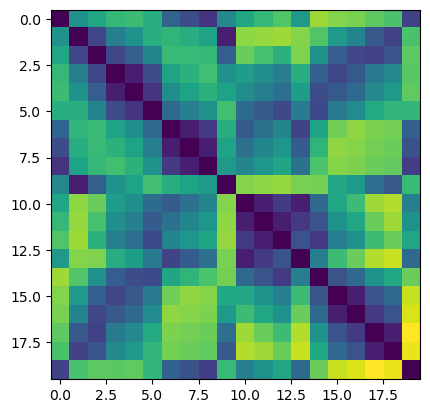

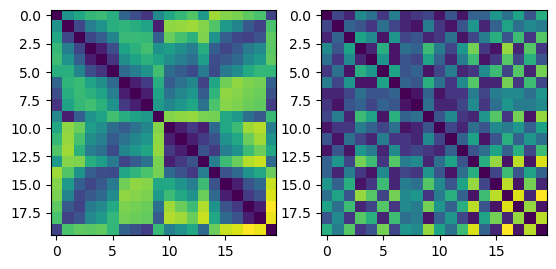

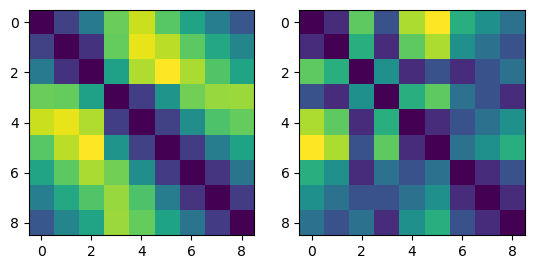

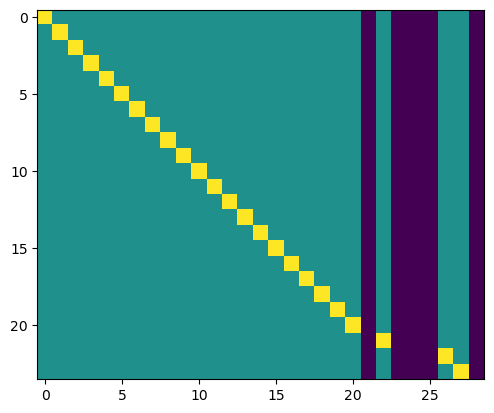

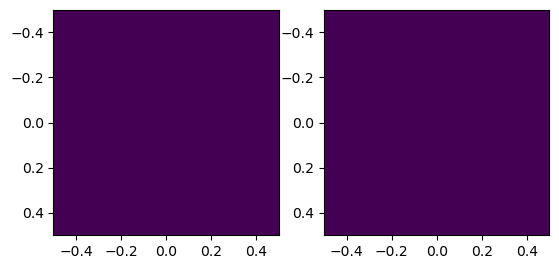

In [309]:
def compiler(file_name, registers, sparsify = False):
    # debug, we don't actually read a file but we generate it randomly
    rete = Program([1,20,10,1], ["RELU","RELU","LINEAR"])
    rete.random_init_weights()
    intermediate_representation = IR(rete)
    #for i in intermediate_representation:
    #    print(i)
    allocator = Allocator(intermediate_representation , rete , registers[2:])
    asm_code = []
    
    #for m in allocator.memory_allocation_data:
    #    m.print()
    #    print("----")
    
    cursor_allocator = 0
   
    for ir_statement in intermediate_representation:
        flattened = ir_statement.flatten()
        #print(flattened)
        if(flattened[0] == "COMMENT"):
            if(flattened[1] == "END"):
                #print("\n # NUOVO BLOCCO \n")
                cursor_allocator += 1
        
        if(flattened[0] == "MOVE" 
           and 
           flattened[3] == "CONST"
          ): # set the temporary variable
            tmp_name = flattened[2]
            val       = flattened[4]
            # we have to understand if tmp_name is a register or not
            if(allocator.register_allocation_data[cursor_allocator].contains(tmp_name)):
                0
                #print("MOV TO $%d THE VALUE #%f" % (
                #      allocator.register_allocation_data[cursor_allocator].get_data()[tmp_name],
                #      val)
                #     )
            else:
                # variable is in memory
                address = allocator.memory_allocation_data[cursor_allocator].get_data()[tmp_name]
                #print("STORE THE VALUE 0 IN ADDRESS %d" % address)
                
                
        if(flattened[0] == "MOVE"
           and
           flattened[3] == "BINOP"
           and 
           len(flattened ) == 13
          ): # addition and multiply
            neuron_dest   = flattened[2]
            neuron_source = flattened[12]
            weight        = flattened[10]
            
            
            if(allocator.register_allocation_data[cursor_allocator].contains(neuron_source)):
                0
                #print("MULT $%d BY #%f AND SAVE IT IN $0" % (
                #      allocator.register_allocation_data[cursor_allocator].get_data()[neuron_source],
                #      weight)
                #     )
            else:
                # variable is in memory
                address = allocator.memory_allocation_data[cursor_allocator].get_data()[neuron_source]
                #print("LOAD IN REGISTER $0 THE ADDRESS %d"  % allocator.memory_allocation_data[cursor_allocator].get_data()[neuron_source])
                #print("MULT $0 BY #%f AND SAVE IT IN $0" % (
                #      weight)
                #     )
            if(allocator.register_allocation_data[cursor_allocator].contains(neuron_dest)):
                0
                #print("ADD $0 to $%d" % (
                #      allocator.register_allocation_data[cursor_allocator].get_data()[neuron_dest])
                #     )
            else:
                # variable is in memory
                address = allocator.memory_allocation_data[cursor_allocator].get_data()[neuron_dest]
                #print("LOAD IN REGISTER $1 THE ADDRESS %d" % address)                
                #print("ADD $0 to $1")
                #print("STORE $1 IN ADDRESS %d" % address)
    
compiler(0, ['a','b','c'])

# Test

## Unicorn emulator

<hr>

In [72]:
1 in {1:3,5:5}

True